# DATA WRANGLING PROJECT
## Wrangle WeRateDogs Twitter Data and Perform Analysis and Visualizations 

### <span style="background-color: yellow">DICTIONARY:</span>  
**<span style="color:red">image_predictions.tsv</span>  
tweet_id : the last part of tweet URL  
jpg_url : the url of the jpg file   
img_num : image number that corresponded to the most confident prediction (up to four)  
p1 : the algorithm's #1 prediction for the image in the tweet  
p1_conf : how confident the algorithm is in its #1 prediction  
p1_dog : whether or not the #1 prediction is a breed of dog  
p2 : the algorithm's #2 prediction for the image in the tweet  
p2_conf : how confident the algorithm is in its #2 prediction  
p2_dog : whether or not the #2 prediction is a breed of dog  
p3 : the algorithm's #3 prediction for the image in the tweet  
p3_conf : how confident the algorithm is in its #3 prediction  
p3_dog : whether or not the #3 prediction is a breed of dog**  

**<span style="color:red">twitter_archive_enhanced.csv</span>  
tweet_id : Tweet id                      
in_reply_to_status_id : status id          
in_reply_to_user_id : user id           
timestamp : timestamp                     
source : url source of tweet                        
text : text from tweet                           
retweeted_status_id : id from retweet           
retweeted_status_user_id : user id from retweet      
retweeted_status_timestamp : timestamp from retweet    
expanded_urls : url where tweet id is at the end                 
rating_numerator : rate people's dogs, mostly larger than 10             
rating_denominator : almost always has a denominator of 10            
name : dog name                          
doggo : big and older dog                         
floofer : any dog, commonly has excess fur                       
pupper : small doggo, usually younger than doggo                        
puppo : teeange dog, between pupper and doggo**

**<span style="color:red">tweet_json.txt</span>  
id : tweet id  
retweet_count : number of times tweet was retweeted  
favorite_count : number of times tweet was labeled favorite**

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

# <span style="background-color: yellow">I. Gather</span>
### The data will be gathered from *three* resources and converted into Pandas dataframes.

In [130]:
# import all necessary libraries
import warnings
warnings.filterwarnings("ignore")
#import warnings; warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
%matplotlib inline

### The 'image_predictions.tsv' file contains information on tweet image predictions.  
### The  <span style="color:red">image</span> dataframe is created. 


In [2]:
# Specify the url to get the 'image_predictions.tsv' file
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
# Packages the request, send the request and catch the response: r
r= requests.get(url)
# Extract the response: text
text = r.text

In [3]:
# create a dataframe from 'tsv' file
data = text
image = pd.DataFrame([x.split('\t') for x in data.split('\n')])

In [4]:
# create a dataframe with header and appropriate indexing
new_header = image.iloc[0] #grab the first row for the header
image = image[1:] #take the data less the header row
image.columns = new_header #set the header row as the df header
image.index = np.arange(0, len(image))  # index from range 0 to len(image) 

### The 'twitter_archive_enhanced.csv' </span> file contains The WeRateDogs Twitter archive.
### The <span style="color:red">archive</span> dataframe is created.

In [5]:
# read the 'twitter-archive-enhanced.csv' file
archive = pd.read_csv('twitter-archive-enhanced.csv')

### The 'tweet_json.txt' file is generated by querying the Twitter API for each tweet id in the archive file. The result is each tweet's entire set of JSON data in a file. 
### The <span style="color:red">tweet</span> dataframe is created. 

In [ ]:
###### RUN ONLY ONCE TO CREATE AUTENTICATION FOR TWITTER API

# Set up authentication to access Twitter API
consumer_key = ''
consumer_secret = ''
access_secret = ''
access_token = ''


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
##### RUN ONLY ONCE TO CREATE TWEET_JSON.TXT

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive

# Create array of values named 'tweet_ids' derived from 'tweet_id' values in 'archive' dataframe
tweet_ids = archive.tweet_id.values
len(tweet_ids)

# initialize variables
count = 0
fails_dict = {}
start = timer()

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
# This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        # set the counter
        count += 1
        # print the counter and the tweet_id string
        print(str(count) + ": " + str(tweet_id))
        # get the tweet from api using the 'get_status' method and write to the 'tweet_json.txt' file
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
            # set up dictionary of failures
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [6]:
#load the json data and store it in a list and then create a dataframe
data = []
with open('tweet_json.txt') as f:    
    for line in f:         
        data.append(json.loads(line))
#create dataframe from json data
tweet = pd.DataFrame(data)
#select columns of interest
columns = ['id', 'retweet_count', 'favorite_count']
tweet = tweet[columns]

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

# <span style="background-color: yellow">II. Assess</span>


In [7]:
# view three top rows of image dataset
image.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.07419169999999999,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.13858399999999998,True,bloodhound,0.11619700000000001,True


In [8]:
# view three top rows of archive dataset
archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [9]:
# view three top rows of tweet dataset
tweet.head(3)

,id,retweet_count,favorite_count
0,892420643555336193,7719,36252
1,892177421306343426,5706,31269
2,891815181378084864,3781,23542


In [10]:
# check for null values and datatypes in image dataset
image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2076 entries, 0 to 2075
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2076 non-null   object
 1   jpg_url   2075 non-null   object
 2   img_num   2075 non-null   object
 3   p1        2075 non-null   object
 4   p1_conf   2075 non-null   object
 5   p1_dog    2075 non-null   object
 6   p2        2075 non-null   object
 7   p2_conf   2075 non-null   object
 8   p2_dog    2075 non-null   object
 9   p3        2075 non-null   object
 10  p3_conf   2075 non-null   object
 11  p3_dog    2075 non-null   object
dtypes: object(12)
memory usage: 210.8+ KB


In [11]:
# check for null values and datatypes in archive dataset
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [12]:
# check for null values and datatypes in tweet dataset
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701 entries, 0 to 1700
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              1701 non-null   int64
 1   retweet_count   1701 non-null   int64
 2   favorite_count  1701 non-null   int64
dtypes: int64(3)
memory usage: 40.0 KB


In [13]:
# check for duplicated vaues of tweet_id and sum them in image dataset
image['tweet_id'].duplicated().sum()

0

In [14]:
# check for duplicated vaues of tweet_id and sum them in tweet dataset
tweet['id'].duplicated().sum()

0

In [15]:
# check for duplicated vaues of tweet_id and sum them in archive dataset
archive['tweet_id'].duplicated().sum()

0

In [16]:
# check value counts for categorical column 'doggo'
archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [17]:
# check value counts for 'floofer'
archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [18]:
# check value counts for 'pupper'
archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [19]:
# check value counts for 'puppo'
archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [20]:
# check value counts for 'rating_numerator' to get an idea of the rating numbers
archive['rating_numerator'].value_counts().head(10)

12    558
11    464
10    461
13    351
9     158
8     102
7      55
14     54
5      37
6      32
Name: rating_numerator, dtype: int64

In [21]:
# check value counts for 'rating_denominator' to get an idea of the rating numbers
archive['rating_denominator'].value_counts().head()

10    2333
11       3
50       3
80       2
20       2
Name: rating_denominator, dtype: int64

In [22]:
# statistical output for 'archive'
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [23]:
# statistical output for 'tweet'
tweet.describe()

,id,retweet_count,favorite_count
count,1.701000e+03,1701.000000,1701.000000
mean,7.583918e+17,3124.835391,8806.403292
std,7.199692e+16,5059.148785,13084.396857
min,6.660209e+17,1.000000,0.000000
25%,6.742626e+17,507.000000,852.000000
50%,7.599238e+17,1757.000000,4452.000000
75%,8.190064e+17,3694.000000,11863.000000
max,8.924206e+17,77938.000000,156416.000000


In [24]:
# statistical output for 'image'
image.describe()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
count,2076,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075,2075
unique,2076,2009,4,378,2006,2,405,2004,2,408,2006,2
top,680176173301628928,https://pbs.twimg.com/media/CwiuEJmW8AAZnit.jpg,1,golden_retriever,0.938048,True,Labrador_retriever,0.0693617,True,Labrador_retriever,0.08446569999999999,True
freq,1,2,1780,150,2,1532,104,3,1553,79,2,1499


In [25]:
# look at some of the most common names
archive['name'].value_counts().head()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
Name: name, dtype: int64

In [26]:
# look at 'name' column with lower case
name_bool = archive['name'].str.islower() 
archive_name = archive[name_bool]
archive_name.name.value_counts()
#archive_name_series.value_counts().head()

a               55
the              8
an               7
very             5
just             4
one              4
quite            4
mad              2
not              2
getting          2
actually         2
incredibly       1
unacceptable     1
life             1
infuriating      1
light            1
his              1
all              1
space            1
this             1
such             1
officially       1
old              1
by               1
my               1
Name: name, dtype: int64

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

## <span style="background-color: yellow">Quality</span>

### <span style="color:red">image table</span>

- **One record has null values**
- **p1, p2 and p3 columns dog breeds contain combination of one word or series of words sperated by underscore. Should be all one word and lowercase for better readability.**
- **'p1_conf', 'p2_conf', and 'p3_conf' should all be float numbers with 6 decimal places for consistency.**
- **The datatypes for the 'tweet_id', 'img_num', 'p1_conf', 'p1_dog', 'p2_conf', 'p2_dog', 'p3_conf',and 'p3_conf' columns are erroneous.**  
 

### <span style="color:red">archive table</span>

- **'Timestamp' column should be datetime datatype.**
- **The 'name' column has erroneous dog names which are lower case. These value should be changed to null.**
- **There are erroneous values in the 'rating_numerator' and 'rating_denominator' columns. The correct numerators and denominators can be extracted from the 'text' variable.**
- **The clean 'rating_numerator' and 'rating_denominator' variables need to be float datatype.**
- **Change datatype of 'doggo', 'floofer', 'pupper' and 'puppo'  columns to integer after the tiding the data.**
- **Change all 'None' values to null for columns that are 2356 non-null for consistencey. These columns are 'source', 'text, and 'name'.**
 




## <span style="background-color: yellow">Tidiness</span>

- **'Tweet_id' column in *image* table duplicated in *archive* and *tweet*  tables.**
- **Four columns (doggo,floofer,pupper,and puppo) should be under one column in *archive* table. The records that have multiple dog stages should be listed as comma-separated dog stages.**


**------------------------------------------------------------------------------------------------------------------------------------------------------------**

# <span style="background-color: yellow">III. Clean</span>

In [27]:
# make copy of dataframes
archive_clean = archive.copy()
image_clean = image.copy()
tweet_clean = tweet.copy()

## <span style="background-color: yellow">Quality : Missing Data</span>

**<span style="background-color: yellow">*image* : One missing record (tweet_id has 2076 non-null values while rest of columns have 2075)**</span>

***Define***

Find which row has null values and drop it.

***Code***

In [28]:
# find the row with the null values and drop it 
image_clean_bool = image_clean['jpg_url'].isnull()
print(image_clean[image_clean_bool])

0    tweet_id jpg_url img_num    p1 p1_conf p1_dog    p2 p2_conf p2_dog    p3  \
2075             None    None  None    None   None  None    None   None  None   

0    p3_conf p3_dog  
2075    None   None  


In [29]:
# drop the row
image_clean.dropna(inplace=True)

***Test***

In [30]:
# check that 'info' method lists all columns as non null
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  2075 non-null   object
 1   jpg_url   2075 non-null   object
 2   img_num   2075 non-null   object
 3   p1        2075 non-null   object
 4   p1_conf   2075 non-null   object
 5   p1_dog    2075 non-null   object
 6   p2        2075 non-null   object
 7   p2_conf   2075 non-null   object
 8   p2_dog    2075 non-null   object
 9   p3        2075 non-null   object
 10  p3_conf   2075 non-null   object
 11  p3_dog    2075 non-null   object
dtypes: object(12)
memory usage: 210.7+ KB


**------------------------------------------------------------------------------------------------------------------------------------------------------------**

## <span style="background-color: yellow">Quality : General</span>

**<span style="background-color: yellow">*image* : p1_conf, p2_conf, p3_conf columns have floats with different decimal places.**</span> 

***Define***

Round off all values in the p1_conf, p2_conf, and p3_conf columns to six decimal places and change datatype to float.

***Code***

In [31]:
# convert the p1_conf, p2_conf, and p3_conf columns to float and round to six decimals
columns = ['p1_conf','p2_conf','p3_conf']
image_clean[columns] = image_clean[columns].astype('float').round(decimals=6)

***Test***

In [32]:
# examine first three rows
image_clean.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [33]:
# examine datatypes 
image_clean[columns].dtypes

0
p1_conf    float64
p2_conf    float64
p3_conf    float64
dtype: object

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">*image* : p1, p2 and p3 columns have a combination of one word values , multiword values and combination of upper and lower case.**</span>

***Define***

Eliminate the underscore in the values representing a different format that of the columns.Change all upper case to lower case. 

***Code***

In [34]:
# For p1 column replace underscore with space and change to lowercase 
image_clean["p1"] = image_clean["p1"].str.replace("_", " ").str.lower()

In [35]:
# For p1 column replace underscore with space and change to lowercase 
image_clean["p2"] = image_clean["p2"].str.replace("_", " ").str.lower()

In [36]:
# For p1 column replace underscore with space and change to lowercase 
image_clean["p3"] = image_clean["p3"].str.replace("_", " ").str.lower()

***Test***

In [37]:
image_clean.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh springer spaniel,0.465074,True,collie,0.156665,True,shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">*image* : Errorneous datatypes for 'tweet_id', 'img_num', 'p1_dog', 'p2_dog', and 'p3_dog' columns.**</span>

***Define***

Change datatypes for following columns :  
tweet_id to int,  
img_num to int,  
p1_dog to bool,  
p2_dog to bool,  
p3_dog to bool.    

***Code***

In [38]:
# change datatypes for columns listed in dictionary
#datatype_dict = {'tweet_id':'int','img_num':'int','p1_dog':'bool','p2_dog':'bool','p3_dog':'bool'}
#image_clean.astype(datatype_dict)
image_clean['tweet_id'] = image_clean['tweet_id'].astype('int')
image_clean['img_num'] = image_clean['img_num'].astype('int')
image_clean['p1_dog'] = image_clean['p1_dog'].astype('bool')
image_clean['p2_dog'] = image_clean['p2_dog'].astype('bool')
image_clean['p3_dog'] = image_clean['p3_dog'].astype('bool')

***Test***

In [39]:
image_clean.dtypes

0
tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">*archive* : Erroreous datatype for timestamp column.**</span>

***Define***

Timestamp column should be datetime datatype with year, month, day, hour, minute, and second.

***Code***

In [40]:
# check datatype for 'timestamp' column
archive_clean['timestamp'].dtype

dtype('O')

In [41]:
# change timestamp to datetime64 datatype
archive_clean["timestamp"] = archive['timestamp'].astype('datetime64')

***Test***

In [42]:
archive_clean['timestamp'].head(1)

0   2017-08-01 16:23:56
Name: timestamp, dtype: datetime64[ns]

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">*archive* : The name column has erroneous words which are all lowercase. Replace these values with 'NaN'**</span>

***Define***

Replace the errorneous words with 'NaN' for the 'name' column 

***Code***

In [43]:
# check for any erroneousl names 
archive_clean[archive_clean.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
just             4
one              4
quite            4
mad              2
not              2
getting          2
actually         2
incredibly       1
unacceptable     1
life             1
infuriating      1
light            1
his              1
all              1
space            1
this             1
such             1
officially       1
old              1
by               1
my               1
Name: name, dtype: int64

In [44]:
# replace all lower case names in 'name' columns with 'NaN'
name_bool = archive_clean.name.str.islower()
archive_clean.loc[name_bool,'name'] = np.nan

***Test***

In [45]:
# check few lines of dataframe
archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [46]:
# check that name column has null values
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [47]:
# check the number of lower case names 
len(archive_clean[archive_clean['name'].str.islower() == True])

0

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

## <span style="background-color: yellow">Tidiness</span>

**<span style="background-color: yellow">*archive* : Four columns (doggo,floofer,pupper,and puppo) should be under one column in *archive* table. Columns should be variable names, not valuesThe records that have multiple dog stages should be listed as comma-separated dog stages.**</span> 

***Define***

A new column dog_stage is created and the column names are inputed as row values. Replace 'None' values in the doggo, floofer, pupper, and puppo columns with empty space and then perform string additon across the rows (vectorization) to filter out the values that contain the dog stage. For records with multiple dog stages use regex and string replacement to produce comma-separated values.  

***Code***

In [48]:
# make copy of archive_clean as backup
archive_tidy = archive_clean.copy()

In [50]:
# change 'None' to empty string for all dog stages
archive_tidy['doggo'].replace('None','',inplace=True)
archive_tidy['floofer'].replace('None','',inplace=True)
archive_tidy['pupper'].replace('None','',inplace=True)
archive_tidy['puppo'].replace('None','',inplace=True)

In [52]:
# perform string additon to filter out the dog_stage across the rows
archive_tidy['dog_stage'] = archive_tidy['doggo'] + archive_tidy['floofer'] + archive_tidy['pupper']+ archive_tidy['puppo']

In [55]:
# example of string with multiple dog stages
archive_tidy.loc[565]['dog_stage']

'doggopupper'

In [57]:
# using regex and replacement to separate the records that contain multiple dog stages by a comma 
archive_tidy['dog_stage'] = archive_tidy['dog_stage'].str.replace('(doggo|pupper|puppo|floofer){1}(doggo|pupper|puppo|floofer){1}', \
                       r'\1,\2', regex=True)

In [58]:
archive_tidy.loc[565]['dog_stage']

'doggo,pupper'

In [59]:
# replace the empty strings with NaN
archive_tidy['dog_stage'] = archive_tidy['dog_stage'].replace(r'^\s*$', np.nan, regex=True)

In [61]:
# drop the doggo, pupper, puppo and floofer columns
archive_tidy.drop(columns=['doggo','pupper','puppo','floofer'], inplace=True)

In [63]:
# rename archive_tidy to archive_clean
archive_clean = archive_tidy

***Test***

In [65]:
# print the value counts of dog_stage
print(archive_clean.dog_stage.value_counts())

pupper           245
doggo             83
puppo             29
doggo,pupper      12
floofer            9
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64


In [78]:
# check info of archive_clean
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

## <span style="background-color: yellow">Quality</span>

**<span style="background-color: yellow">*archive* : The columns 'name', 'source', and 'text' that have 2356 non-null objects should have the 'None' values converted to null.</span>**

***Define***

Convert 'None' values in columns 'name', 'source', and 'text' to null. 

***Code***

In [79]:
# query 'None' value in the name
len(archive_clean.query('name == "None"'))

745

In [80]:
# query 'None' value in the source
len(archive_clean.query('source == "None"'))

0

In [81]:
# query 'None' value in the text
len(archive_clean.query('text == "None"'))

0

In [82]:
# replace 'None' with null for name column
archive_clean['name'].replace('None', np.nan, inplace=True)

***Test***

In [83]:
# test that the length of 'name' column with 'None' value is 0
len(archive_clean.query('name == "None"'))

0

In [84]:
# check few rows in name column
archive_clean['name'].head(6)

0     Phineas
1       Tilly
2      Archie
3       Darla
4    Franklin
5         NaN
Name: name, dtype: object

In [85]:
# check few lines of archive dataframe
archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN


In [86]:
# check datatypes and non-null values
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [87]:
archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">*archive* : The 'rating_numerator' and 'rating_denominator' columns have erroneous values.**</span>

***Define***

Extract the correct for rating_numerator and rating_denominator from the 'text' column.

***Code***

In [88]:
# make copy of archive_clean for backup
archive_clean_rate = archive_clean.copy()

In [89]:
# query an example where rating_numerator does not match rating numerator in text. For this query, 
# rating numerator is 75
archive_clean_rate.query('tweet_id == "786709082849828864"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,NaN


In [90]:
# query the 'text' column for tweet_id == "786709082849828864". The rating numerator is 9.75 NOT 75. 
archive_clean_rate.iloc[695][5]

"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"

In [91]:
# The ratings dataframe extract whole numbers and decimal numbers from both numerator and
# denominator for the 'text' column
ratings = archive_clean_rate.text.str.extract('((?:\d+\.)?\d+)\/((?:\d+\.)?\d+)',expand=True)
ratings                                             

,0,1
0,13,10
1,13,10
2,12,10
3,13,10
4,12,10
...,...,...
2351,5,10
2352,6,10
2353,9,10
2354,7,10


In [92]:
# rating has two columns with datatype integer
ratings.columns

Int64Index([0, 1], dtype='int64')

In [93]:
# the ratings dataframe aligns with the archive_clean_rate dataframe
ratings.iloc[695][0]

'9.75'

In [94]:
# convert integer column types to string
ratings.columns = ratings.columns.astype(str)

In [95]:
ratings.columns

Index(['0', '1'], dtype='object')

In [96]:
# replace rating_numerator and rating_denominator columns in archive_clean_rate with those in ratings
archive_clean_rate[['rating_numerator','rating_denominator']] = ratings[['0','1']]

***Test***

In [97]:
archive_clean_rate.iloc[695][5]

"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"

In [98]:
# Now archive_clean_rate has the correct rating numerator which is 9.75 NOT 75
archive_clean_rate.query('tweet_id == "786709082849828864"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,NaN


In [99]:
# rename archive_clean_rate to archive_clean
archive_clean = archive_clean_rate

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">*archive* : Change the datatype of 'rating_numerator' and 'rating_denominator' to float datatype.</span>**

***Define***

Use the astype function to convert the 'rating_numerator' and 'rating_denominator' to float datatype

***Code***

In [100]:
archive_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                      object
rating_denominator                    object
name                                  object
dog_stage                             object
dtype: object

In [101]:
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype(float)
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].astype(float)

***Test***

In [102]:
archive_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                     float64
rating_denominator                   float64
name                                  object
dog_stage                             object
dtype: object

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

## <span style="background-color: yellow">Tidiness</span>

**<span style="background-color: yellow">*archive, image and tweet* : All datasets contain tweet_id and can be merged on that column.**</span>

***Define***

For the 'tweet' dataframe rename the 'id' column to 'tweet_id'. For the three dataframe perform the merge method on the 'tweet_id' column. 

***Code***

In [103]:
# check archive_clean columns and shape
print(archive_clean.columns)
print(archive_clean.shape)

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'dog_stage'],
      dtype='object')
(2356, 14)


In [104]:
# check tweet_clean columns
print(tweet_clean.columns)
print(tweet_clean.shape)

Index(['id', 'retweet_count', 'favorite_count'], dtype='object')
(1701, 3)


In [105]:
# check image_clean columns
print(image_clean.columns)
print(image_clean.shape)

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object', name=0)
(2075, 12)


In [106]:
# rename 'id' column in tweet_clean to 'tweet_id'
tweet_clean.rename(columns = {'id': 'tweet_id'}, inplace=True)

In [107]:
# perform outer merge on archive_clean and image_clean and assign to 'merge1'. This will include all matching
# non matching tweet_id but no duplicates of tweet_id
merge1 = pd.merge(archive_clean, image_clean, on='tweet_id', how='outer')

In [108]:
merge1.shape

(2356, 25)

In [109]:
# perform inner merge on tweet_clean and merge1 and assign to 'merge2'
merge2 = pd.merge(merge1, tweet_clean, on='tweet_id', how='outer')

In [110]:
merge2.shape

(2356, 27)

In [111]:
# name the final merge dataframe 'twitter_archive_master'
twitter_archive_master = merge2

In [112]:
# write dataframe to csv file with no extra columns
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

***Test***

In [113]:
# check shape of 'twitter_archive_master'
twitter_archive_master.shape

(2356, 27)

In [114]:
# check few rows of new dataframe
twitter_archive_master.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,True,bagel,0.085851,True,banana,0.076110,True,7719.0,36252.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,pekinese,0.090646,True,papillon,0.068957,True,5706.0,31269.0


In [115]:
# check the size and unique values of new dataframe
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   float64       
 11  rating_denominator          2356 non-null   float64     

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

# <span style="background-color: yellow">III. ANALYSIS</span>

### <span style="color:red">Analysis for the Twitter_archive_master Dataset</span>

- **How does the sum of all retweets for a given day vary over time?**
- **How does the confidence of the three algorithm predictions compare to one another?**
- **Is there a relationship between retweet_count and favorite_count?**

### <span style="color:red">Visualization</span>

- **How do the dog stages('doggo', 'floofer', 'pupper', 'puppo') relate to rating_numerator?**




**<span style="background-color: yellow">How does the favorite count correlate with retweet count for each dog tweet?</span>**

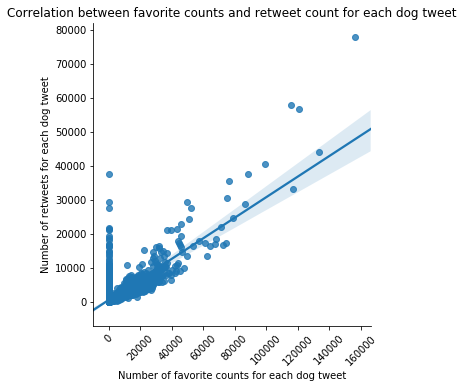

In [122]:
sns.lmplot(x='favorite_count', y='retweet_count', data=twitter_archive_master)
plt.xlabel('Number of favorite counts for each dog tweet')
plt.ylabel('Number of retweets for each dog tweet')
plt.title('Correlation between favorite counts and retweet count for each dog tweet')
plt.xticks(rotation=45)
plt.show()

In [123]:
# calculate the correlation between 'retweet_count' and 'favorite_count'
twitter_archive_master['retweet_count'].corr(twitter_archive_master['favorite_count'])

0.7838886834353888

**<span style="background-color:yellow">Conclusion :</span>There is a high correlation of 78% between retweet_count and favorite_count.**

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">How does the confidence of the three algorithm predictions compare to one another?</span>**

In [124]:
# create p1_pred dataframe with confidence proportion and category of p1_conf
p1_pred = twitter_archive_master['p1_conf']
p1_pred = p1_pred.to_frame()
p1_pred['algorithm'] = 'p1_alg'
p1_pred.rename( columns = {'p1_conf' : 'conf'}, inplace=True)
p1_pred.head(1)

,conf,algorithm
0,0.097049,p1_alg


In [125]:
# create p1_pred dataframe with confidence proportion and category of p1_conf
p2_pred = twitter_archive_master['p2_conf']
p2_pred = p2_pred.to_frame()
p2_pred['algorithm'] = 'p2_alg'
p2_pred.rename( columns = {'p2_conf' : 'conf'}, inplace=True)
p2_pred.head(1)

,conf,algorithm
0,0.085851,p2_alg


In [126]:
# create p1_pred dataframe with confidence proportion and category of p1_conf
p3_pred = twitter_archive_master['p3_conf']
p3_pred = p3_pred.to_frame()
p3_pred['algorithm'] = 'p3_alg'
p3_pred.rename( columns = {'p3_conf' : 'conf'}, inplace=True)
p3_pred.head(1)

,conf,algorithm
0,0.07611,p3_alg


In [127]:
# concatenate the three prediction dataframes
pred_concat = pd.concat([p1_pred,p2_pred,p3_pred])
pred_concat.head(1)

,conf,algorithm
0,0.097049,p1_alg


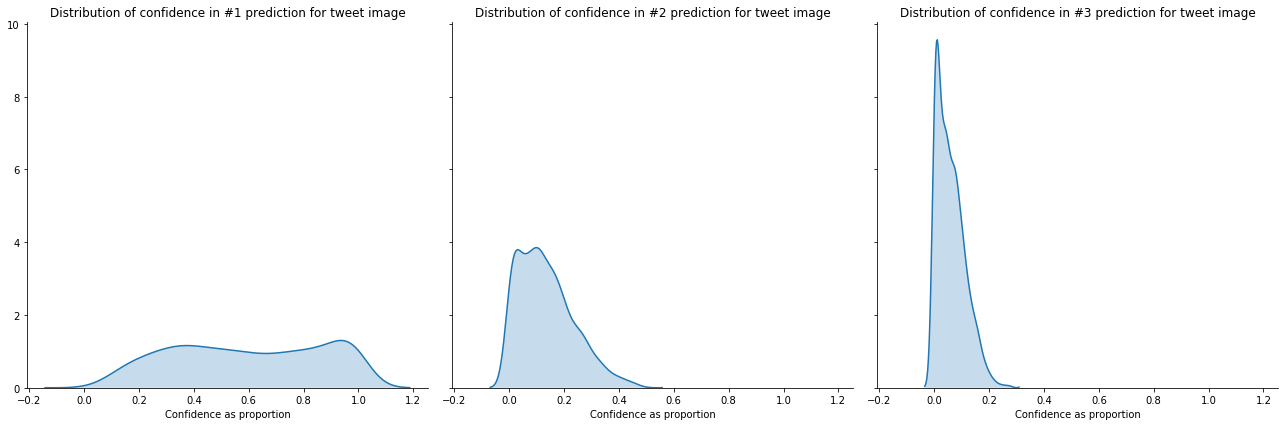

In [131]:
g = sns.FacetGrid(pred_concat, col="algorithm", size=6)
g.map(sns.kdeplot, "conf", shade=True)
g.set_xlabels('Confidence as proportion')
g.axes[0,0].set_title('Distribution of confidence in #1 prediction for tweet image')
g.axes[0,1].set_title('Distribution of confidence in #2 prediction for tweet image')
g.axes[0,2].set_title('Distribution of confidence in #3 prediction for tweet image')
plt.show()

In [132]:
# show columns of pred_concat
pred_concat.columns

Index(['conf', 'algorithm'], dtype='object')

In [133]:
# find mean of confidence prediction 1,2 and 3 grouped by algorithm
print(pred_concat.groupby('algorithm').mean())

               conf
algorithm          
p1_alg     0.594548
p2_alg     0.134589
p3_alg     0.060324


**<span style="background-color:yellow">Conclusion :</span>For a particular tweet_id, the confidence of the algorithm's #1 prediction has an average that is higher than either #2 prediction and #3 prediction.
The #3 prediction has the lowest confidence proportion.**

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

**<span style="background-color: yellow">How does the sum of all retweets for a given day vary over time? </span>**

In [144]:
# create dataframe with timestamp and retweet_count
tweets_time2 = twitter_archive_master[['timestamp', 'retweet_count']]

In [145]:
# extract year, month and day from timestamp column
tweets_time2['date'] = pd.to_datetime(tweets_time2['timestamp'].dt.strftime('%Y-%m-%d'))

In [146]:
# check datatypes
tweets_time2.dtypes

timestamp        datetime64[ns]
retweet_count           float64
date             datetime64[ns]
dtype: object

In [137]:
# drop timetamp column
tweets_time2.drop(['timestamp'], axis=1, inplace=True)

In [138]:
# create dataframe that is grouped by date and summed by retweet_count
tweets_group = tweets_time2.groupby('date', as_index=False).agg({"retweet_count" : "sum"})

In [139]:
# set index for new dataframe to date 
tweets_group = tweets_group.set_index('date')

In [140]:
# show few lines of tweets_group
tweets_group.head(2)

,retweet_count
date,
2015-11-15,545.0
2015-11-16,9382.0


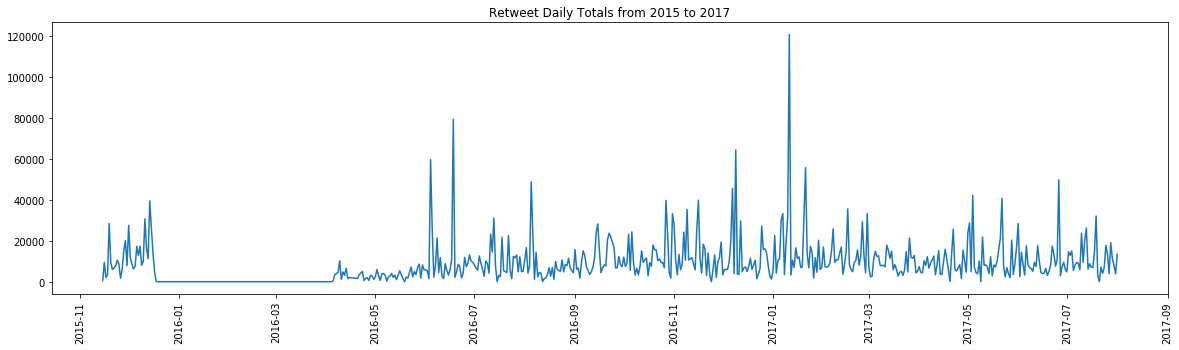

In [141]:
#fig,ax = plt.subplots()
plt.figure(figsize=(20,5))
plt.plot(tweets_group)
plt.xticks(rotation=90)
plt.title('Retweet Daily Totals from 2015 to 2017')
plt.show()

In [142]:
# view statistics of different time periods which show a significate variation
view1 = tweets_group['2015-11-15':'2016-05-10']
view1.describe()

,retweet_count
count,173.000000
mean,2908.595376
std,6278.494554
min,0.000000
25%,0.000000
50%,0.000000
75%,2950.000000
max,39473.000000


In [143]:
view2 = tweets_group['2017-01-01':'2017-03-31']
view2.describe()

,retweet_count
count,88.000000
mean,13457.727273
std,14726.772518
min,1766.000000
25%,6003.500000
50%,10493.500000
75%,15034.750000
max,120751.000000


**<span style="background-color:yellow">Conclusion :</span>When twitter users first experience a new twitter account such as WeRateDogs , they might not retweet that much since they are new to it. After twitter users get used to the account there is more retweet activity as show from the time series plot above.**

**------------------------------------------------------------------------------------------------------------------------------------------------------------**

### <span style="color:red">Visualization</span>

**<span style="background-color:yellow">How do the dog stages ('doggo', 'floofer', 'pupper', 'puppo') relate to rating_numerato for a given tweet_id.</span>**

In [116]:
twitter_archive_master.dog_stage.value_counts()

pupper           245
doggo             83
puppo             29
doggo,pupper      12
floofer            9
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64

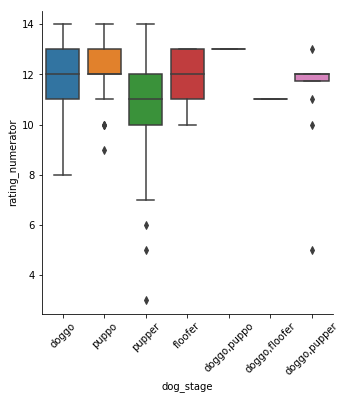

In [120]:
sns.catplot(x='dog_stage', y='rating_numerator',data=twitter_archive_master, kind="box")
plt.xticks(rotation=45)
plt.show()

In [121]:
# get the mean of rating_numerator by dog_stage
twitter_archive_master.groupby('dog_stage')['rating_numerator'].mean()

dog_stage
doggo            11.879518
doggo,floofer    11.000000
doggo,pupper     11.250000
doggo,puppo      13.000000
floofer          11.888889
pupper           10.788857
puppo            12.103448
Name: rating_numerator, dtype: float64

**<span style="background-color:yellow">Conclusion :</span>Out of the dog stage categories that have more than one record, the puppo dog stage has the highest rating numerator average.**